<a href="https://colab.research.google.com/github/james811223/Bit-Coin-stock-price-prediction-with-RNN_LSTM/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up

In [0]:
if 1==1:
    !sudo pip install tensorflow --upgrade
    !pip install --user --upgrade plotnine
    import tensorflow as tf,numpy as np,pandas as pd
    from plotnine import *
    !pip install dfply
    from dfply import *
    from sklearn.preprocessing import MinMaxScaler as scale
    %matplotlib inline
    theme_update(plot_background = element_rect(fill = "orange"),panel_background = element_rect(fill = "silver",colour = "blue",size = 1.99,linetype = "solid"),plot_title = element_text(hjust = 0.5))

# Read in data

In [0]:
data=pd.read_csv('https://raw.githubusercontent.com/james811223/Data/master/BTC-USD.csv',parse_dates=['Date'])

# Classes for building RNN and graphing

In [0]:
class gg_plot:
    '''
    Wrapper class for plotnine.
    Parameters
    ============================================================================
        data(dataframe): Default data for the plot.
        x,y(str): X/Y aesthetic mapping.
        group(str): Column name for the data to be grouped.
    '''
    def __init__(self,data,x=None,y=None,group=None):
        mapping=[]
        self.codes=[]
        self.df=data
        if x is not None:mapping+=["x='"+x+"'"]
        if y is not None:mapping+=["y='"+y+"'"]
        if group is not None:mapping+=["group='"+group+"'"]
        code='ggplot(aes('+','.join(mapping)+'),self.df)'
        self.codes+=[code]

    def line(self,col_grp=None,col=None,title=None,x_lab=None,tilt_x=None):
        '''
        Sets up line plot.
        Parameters
        =========================================================================================
            col_grp(optional str): Column name for the data to be grouped using different colors.
            col(optional str): Color to be used for the line without grouping.
            title(optional str): Title to be used.
            x_lab(optional str): Label for x axis.
            tilt_x(optional int): Angle(degree) to tilt x axis labels.
        '''
        mapping=[]
        if col_grp is not None:mapping+=["aes(color='"+col_grp+"')"]
        if col is not None:mapping+=["color='"+col+"'"]
        code='geom_line('+','.join(mapping)+')'
        self.codes+=[code]
        if title is not None:
            self.codes+=["ggtitle('"+title+"')"]
        if x_lab is not None:
            self.codes+=["xlab('"+x_lab+"')"]
        if x_lab is not None:
            self.codes+=['theme(axis_text_x = element_text(angle = '+str(tilt_x)+', hjust = 1))']

    @property
    def plot(self):
        '''
        Shows the plot.
        '''
        print(eval('+'.join(self.codes)))

    @property
    def code(self):
        '''
        Returns the code used for the graph as a string.
        '''
        return '+'.join(self.codes).replace('self.df','dataframe_object')

dense=tf.keras.layers.Dense
lstm=tf.keras.layers.LSTM
Dropout=tf.keras.layers.Dropout
class rnn:
    def __init__(self,data,train_size,windows=60,date_col=None,lab_col=None):
        '''
        Wrapper class to build RNN(LSTM) model with Tensorflow and Keras.
        Current version supports time series data only.
        Parameters
        =====================================================================================================================================
        data(numpy array): Data to be used.
        train_size(int or float): 
            If int, the specified amount of data will be used for training.
            If float(in between 0 and 1), the specified portion of data will be used for training.
        windows(int defaults to 60): Number of data in the past time steps or sequences to be used to predict 1 time step or instance ahead.
        date_col(optional int): Column index which has the date.
        lab_col(optional int): Column index which has the label. Needed only if have multiple input data for each instance.
        '''
        n=data.shape[0];ncol=len(data.shape)
        if date_col is not None:
            self.date=data[:,date_col]
            data=np.delete(data,date_col,axis=1)
            if date_col<lab_col and ncol>2:lab_col=lab_col-1
        self.data=self.preprocess(data)
        n_in=self.data.shape[-1]
        if type(train_size)!=int:train_size=round(n*train_size)
        self.windows=windows
        self.lab_col=lab_col
        for i in ['train','test']:
            for j in ['x','y']:
                exec('self.'+j+'_'+i+'=[]')
        for i in range(windows,n):
            if i < windows+train_size:
                self.fn('train',i)
            else:
                self.fn('test',i)
        for i in ['train','test']:
            for j in ['x','y']:
                exec('self.'+j+'_'+i+'=np.array(self.'+j+'_'+i+')')
                if j=='x':
                    name='self.'+j+'_'+i
                    exec(name+'='+name+'.reshape([-1,windows,n_in])')

    def preprocess(self,x):
        #dict_={}
        #dict_['diff']=(x[1:]-x[:-1])/x[:-1]
        #dict_['diff_cut']=pd.cut(dict_['diff'],[-1,-.03,0,.03,1],labels=['--3%','-0~3%','+0~3%','++3%'])
        #dict_['1hot']=pd.get_dummies(dict_['diff_cut'])
        #return dict_
        if len(x.shape)==1:x=x.reshape(-1,1)
        self.scaler=scale()
        self.scaler.fit(x)
        return self.scaler.transform(x)

    def reverse_scale(self,x):
        '''
        Reverse scaling for the label data.
        '''
        return (x-self.scaler.min_[self.lab_col])/self.scaler.scale_[self.lab_col]

    def fn(self,suffix,i):
        exec('self.x_'+suffix+"+=[self.data[i-self.windows:i]]")
        if self.lab_col is not None:
            exec('self.y_'+suffix+"+=[self.data[i,self.lab_col]]")
        else:
            exec('self.y_'+suffix+"+=[self.data[i]]")

    def build(self,neurons=100,drop=0.0,activation='relu',dense_units=None,dense_activation=None):
        '''
        Builds the RNN model.
        Parameters
        ===============================================================================================================================================
        neurons(int or list of int defaults to 100):
            If int, one LSTM layer of specified number of neurons will be used.
            if list of int, multiple LSTM layers of specified number of neurons will be used.
        drop(float or list of float(between 0 and 1) defaults to 0.0):
            if float, all LSTM layers will have specified portion of neurons to be droped.
            if list of float, all LSTM layers will have specified portion of neurons to be droped, where drop portion could be different for each layer.
        activation(str or list of str defaults to relu):
            if str, all LSTM layers will use specified activation function.
            if list of str, all LSTM layers will use specified activation function, where activation function could be different for each layer.
        dense_units(optional int): If specified, 1 extra dense layer will be used with specified number of neurons.
        dense_activation(optional str): If specified, the extra dense layer will used the specified activation function.
        '''
        self.model=tf.keras.Sequential(name='RNN_LSTM')
        if type(neurons)==int:
            self.model.add(layer=lstm(units=neurons,activation=activation,dropout=drop,input_shape=self.x_train.shape[1:]))
        else:
            if type(drop)==float:
                drop=[drop for i in range(len(neurons))]
            if type(activation)==str:
                activation=[activation for i in range(len(neurons))]
            i=1
            for n,d,a in zip(neurons,drop,activation):
                if i==1:
                    i+=1
                    self.model.add(layer=lstm(units=n,activation=a,return_sequences=1==1,input_shape=self.x_train.shape[1:]))
                    self.model.add(Dropout(d))
                elif i < len(neurons):
                    i+=1
                    self.model.add(layer=lstm(units=n,activation=a,return_sequences=1==1))
                    self.model.add(Dropout(d))
                else:
                    self.model.add(layer=lstm(units=n,activation=a))
                    self.model.add(Dropout(d))
        if dense_units is not None:
            self.model.add(dense(dense_units,activation=dense_activation))
        self.model.add(dense(1))
        self.model.summary()

    def train(self,lr=.001,optimizer='adam',loss='mean_squared_error',metrics=['mean_absolute_error'],validation_split=0.1,batch_size=32,epochs=50,verbose=1,plot=1==1):
        '''
        Parameters
        =================================================================================================================================================
        lr(float defaults to .001): The learning rate.
        optimizer(str defaults to adam): Name of optimizer or optimizer instance. Refer to tf.keras.optimizers for more info.
        loss(str or tf.losses.Loss instance defaults to mean_squared_error): 
            Name of objective function. See tf.losses. If the model has multiple outputs,you can use a different loss on each 
            output by passing a dictionary or a list of losses. The loss value that will be minimized by the model will then 
            be the sum of all individual losses.
        metrics:
            List of metrics to be evaluated by the model during training and testing. Typically you will use metrics=['accuracy']. 
            To specify different metrics for different outputs of a multi-output model, you could also pass a dictionary, such as 
            metrics={'output_a': 'accuracy', 'output_b': ['accuracy', 'mse']}. You can also pass a list (len = len(outputs)) of lists 
            of metrics such as metrics=[['accuracy'], ['accuracy', 'mse']] or metrics=['accuracy', ['accuracy', 'mse']].
        validation_split:
            Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction 
            of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each 
            epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling. 
        batch_size:
            Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the 
            batch_size if your data is in the form of symbolic tensors, datasets, generators, or keras.utils.Sequence instances (since they generate batches).
        epochs:
            Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in 
            conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, 
            but merely until the epoch of index epochs is reached.
        verbose:
            0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. Note that the progress bar is not particularly useful when logged 
            to a file, so verbose=2 is recommended when not running interactively (eg, in a production environment).
        plot(bool defaults to True): Whether to plot the time series for testing data or not.
        '''
        self.model.compile(optimizer=optimizer,loss=loss,metrics=metrics,learning_rate=lr)
        self.history=self.model.fit(self.x_train, self.y_train, epochs=epochs, batch_size=batch_size,verbose=verbose,validation_split=validation_split)
        mae0=self.model.evaluate(self.x_test,self.y_test,verbose=0)[-1]
        try: 
            mae=self.scaler.inverse_transform(np.array(mae0).reshape(-1,1))
            print('\nTesting data mean absolute error: {}'.format(mae[0,0]))
        except: 
            mae=self.reverse_scale(mae0)
            print('\nTesting data mean absolute error: {}'.format(mae))
        
        if plot:
            prediction=self.predict(self.x_test)
            if self.x_train.shape[-1]==1:actual=self.scaler.inverse_transform(self.y_test).reshape(-1)
            else:actual=self.reverse_scale(self.y_test).reshape(-1)
            label=['Actual' for i in range(actual.shape[0])]+['Forecast' for i in range(actual.shape[0])]
            df=pd.DataFrame({'Stock_price':np.append(actual,prediction),'Label':label})
            n=int(df.shape[0]/2)
            df['Date']=list(self.date[-n:])+list(self.date[-n:])
            graph=gg_plot(df,'Date','Stock_price')
            graph.line(col_grp='Label',title='Time Series Plot For Testing Data',x_lab='',tilt_x=45)
            graph.plot

    def diagnose(self,start=6):
        '''
        Plot a line plot to show losses for training and validation data, where start specifies the starting epoch to plot.
        '''
        loss=self.history.history['loss']+self.history.history['val_loss']
        epoch=list(range(1,int(len(loss)/2+1)))
        epoch+=epoch
        lab=['Training' for i in range(int(len(loss)/2))]+['Validation' for i in range(int(len(loss)/2))]
        df=pd.DataFrame({'Loss':loss,'Epoch':epoch,'Label':lab})
        graph=gg_plot(df[df['Epoch']>start-1],'Epoch','Loss')
        graph.line(col_grp='Label')
        graph.plot

    def predict(self,x):
        if len(x.shape)!=3:x=x.reshape(-1,self.windows,self.x_train.shape[-1])
        prediction=self.model.predict(x)
        if self.x_train.shape[-1]>1:
            prediction=self.reverse_scale(prediction)
        else:
            prediction=self.scaler.inverse_transform(prediction)
        return prediction.reshape(-1)

Model: "RNN_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________
Train on 1545 samples, validate on 191 samples
Epoch 1/50
1545/1545 [==============================] - 4s 3ms/sample - loss: 0.0020 - mean_absolute_error: 0.0215 - val_loss: 9.5004e-04 - val_mean_absolute_error: 0.0203
Epoch 2/50
1545/1545 [==============================] - 2s 2ms/sample - loss: 6.5864e-04 - mean_absolute_error: 0.0116 - val_loss: 8.1592e-04 - val_mean_absolute_error: 0.0188
Epoch 3/50
1545/1545 [==============================] - 2s 2ms/sample - loss: 5.4808e-04 - mean_absolute_error: 0.0109 - 

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


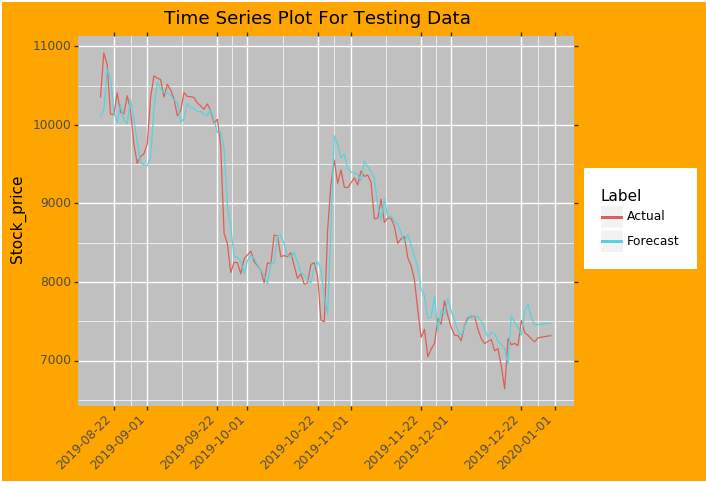

<ggplot: (8771040856766)>


In [7]:
t=rnn(data.values,.9,date_col=0,lab_col=4)
t.build(100,activation='relu',dense_units=None,dense_activation=None,drop=0.0)
t.train(epochs=50,lr=.3,optimizer='adam',validation_split=.11)

# Example of prediction

In [10]:
t.predict(t.x_test[:5])

array([10108.18 , 10183.469, 10710.028, 10593.917, 10157.996],
      dtype=float32)